In [2]:
import warnings

import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import(
    classification_report, accuracy_score, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [3]:
warnings.filterwarnings("ignore")

In [4]:
def load_and_explore_dataset(filepath):
    print("=" * 60)
    print("LOAD AND  EXPLORE DATASET")
    print("=" * 60)

    df = pd.read_csv(filepath)
    print("Shape of the dataset")
    print(df.shape)
    print("\nCheck for missing values")
    print(df.isnull().sum())
    print("\nFirst five rows:")
    print(df.head())
    print("\nDescriptive stats")
    print(df.describe())
    print("\nDataset Info")
    print(df.info())
    print("\nChurn Status Distribution:")
    print(df["Churn_status"].value_counts())
    print("\nChurn Status percentage Distribution:")
    print(df["Churn_status"].value_counts(normalize=True) * 100)

    return df

In [5]:
def identify_features(df):
    print("=" * 60)
    print("IDENTIFY FEATURE DATASET")
    print("=" * 60)

    numerical_features = [
        "Age",
        "Married",
        "Number of Referrals",
        "Tenure in Months",
        "Phone Service",
        "Multiple Lines",
        "Internet Service",
        "Total_Internet_Services",
        "Total Revenue"
    ]

    categorical_features = [
        "Gender",
        "City",
        "Offer",
        "Internet Type",
        "Contract",
        "Payment Method"
    ]

    
    print("\nNumerical features :", numerical_features)
    print("Categirical features :", categorical_features)

    return numerical_features, categorical_features

In [6]:
def prepare_data(df, numerical_features, categorical_features):
    print("=" * 60)
    print("PREPARE DATASET")
    print("=" * 60)

    target_column = "Churn_status"

    X = df[numerical_features + categorical_features]
    y = df[target_column]

    print("\nFeature shape:", X.shape)
    print("\nTarget shape :", y.shape)
    print("\nFeature columns list:", list(X.columns))

    return X, y, list(X.columns)

In [7]:
def create_preprossesing_pipeline(numerical_features, categorical_features):
    print("=" * 60)
    print("CREATING PREPROCESSNG PIPELINE")
    print("=" * 60)

    # numerical features pipeline
    numerical_pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])

    # categorical features pipeline
    categorical_pipeline = Pipeline([
        ("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    ])

    # column preprocesing
    preprocessor = ColumnTransformer([
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features)
    ])

    return preprocessor

In [8]:
def split_data(X, y, test_size=0.2, random_state=42):
    print("\n" + "=" * 60)
    print("SPLITING DATA INTO TEST/TRAIN")
    print("=" * 60)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print("\nTraining set size", X_train.shape[0])
    print("Testing set size", X_test.shape[0])
    print("Train medical status distribution", y_train.value_counts())
    print("Test medical status distribution", y_test.value_counts())
    
    return X_train, X_test, y_train, y_test

In [9]:
def create_model_pipeline(preprocessor):
    print("\n" + "=" * 60)
    print("CREATING MODEL PIPELINE")
    print("=" * 60)

    lr_model = Pipeline([
        ("preprocessor", preprocessor),
        # ("classifier", LogisticRegression(
        #     max_iter= 1000,
        #     random_state=42,
        #     class_weight="balanced",
        #     solver="lbfgs"
        # ))
        ("decisiontree", DecisionTreeClassifier(max_depth=8, random_state=42))
    ])

    print("\nModel created successfully")

    return lr_model

In [14]:
def train_model(lr_model, X_train, y_train):
    print("\n" + "=" * 60)
    print("TRAINING MODEL")
    print("=" * 60)

    lr_model.fit(X_train, y_train)

    print("\nModel train successfully")

    #get name steps preprocessing
    try:
        # Get preprocessor
        preprocessor = lr_model.named_steps["preprocessor"]

        # Get feature names automatically
        feature_names = preprocessor.get_feature_names_out()

        # Get coefficients
        # classifier = model.named_steps["classifier"]
        # coefficients = classifier.coef_[0]
        tree_model = lr_model.steps[-1][1]
        importances = tree_model.feature_importances_
        

        feature_importance = (
            pd.DataFrame({
                "feature": feature_names,
                "importance": importances
                # "coefficient": coefficients
            })
            .sort_values("importance", key=abs, ascending=False)
        )

        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10).to_string(index=False))

    except Exception as e:
        print(f"Could not extract feature names: {e}")

    return lr_model

In [11]:
def evaluate_model(lr_model, X_train, X_test, y_train, y_test):
    print("\n" + "=" * 60)
    print("EVALUATING MODEL")
    print("=" * 60)

    #predicted model
    y_train_pred = lr_model.predict(X_train)
    y_test_pred = lr_model.predict(X_test)

    # predicted model prob
    y_train_proba = lr_model.predict_proba(X_train)[:, 1]
    y_test_proba = lr_model.predict_proba(X_test)[:, 1]
    
    # metrics
    y_train_acc_score = accuracy_score(y_train, y_train_pred)
    y_test_acc_score = accuracy_score(y_test, y_test_pred)

    y_train_roc_score = roc_auc_score(y_train, y_train_proba)
    y_test_roc_score = roc_auc_score(y_test, y_test_proba)

    print("\nMETRICS EVALUATION")
    print(f"\nTrain accuracy score:, {float(y_train_acc_score):.4f}")
    print(f"\nTest accuracy score:, {float(y_test_acc_score):.4f}")
    print(f"\nTrain ROC score:, {float(y_train_roc_score):.4f}")
    print(f"\nTest ROC score:, {float(y_test_roc_score):.4f}")

    print("\nCLASSIFICATION OF TRAIN SIZE")
    print("\nclassificatin report\n", classification_report(y_train, y_train_pred, target_names=["Negative", "positive"]))

    print("\nCLASSIFICATION OF TRAIN SIZE")
    print("\nclassificatin report\n", classification_report(y_test, y_test_pred, target_names=["Negative", "Positive"]))

    # cross validation
    cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring="roc_auc")
    print("\nCross Validation (5-folds)")
    print(f" R2 scores: {cv_scores}")
    print(f" Cross validation mean: {cv_scores.mean():.4f}")
    print(f" Cross validation STD: {cv_scores.std():.4f}")

    metrics = {
        "y_train_acc_score":  y_train_acc_score,
        "y_test_acc_score": y_test_acc_score,
        "y_train_roc_score": y_train_roc_score,
        "y_test_roc_score": y_test_roc_score,
        "y_train_pred":  y_train_pred,
        "y_test_pred": y_test_pred,
        "y_train_proba": y_train_proba,
        "y_test_proba": y_test_proba,
        "cv_scores": cv_scores 
    }

In [12]:
def visual_eval(lr_model, X_test, y_test):
    print("\n" + "=" * 60)
    print("VISUAL EVALUATION")
    print("=" * 60)

    print("\nPrecision Recall Dispaly\n")
    precision_display = PrecisionRecallDisplay.from_estimator(lr_model, X_test, y_test)
    plt.title("Precision-Recall Curve")
    plt.show()

    print("\nRocCurve Dispaly\n")
    curve_display = RocCurveDisplay.from_estimator(lr_model, X_test, y_test)
    plt.title("ROC Curve")
    plt.show()
    
    return precision_display, curve_display

LOAD AND  EXPLORE DATASET
Shape of the dataset
(6920, 40)

Check for missing values
Gender                                 0
Age                                    0
Married                                0
Number of Dependents                   0
City                                   0
Zip Code                               0
Latitude                               0
Longitude                              0
Number of Referrals                    0
Tenure in Months                       0
Offer                                  0
Phone Service                          0
Avg Monthly Long Distance Charges      0
Multiple Lines                         0
Internet Service                       0
Internet Type                          0
Avg Monthly GB Download                0
Online Security                        0
Online Backup                          0
Device Protection Plan                 0
Premium Tech Support                   0
Streaming TV                           0
Streaming Movi

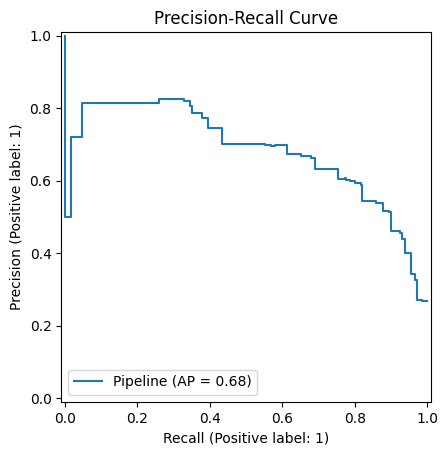


RocCurve Dispaly



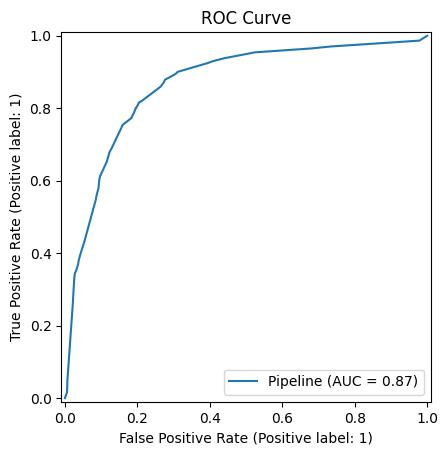

In [15]:
def main():
    filepath = "../data/cleaned/model_telecom_customer_churn.csv"
    
    df = load_and_explore_dataset(filepath)

    numerical_features, categorical_features = identify_features(df)

    X, y, feature_columns = prepare_data(df, numerical_features, categorical_features)

    preprocessor = create_preprossesing_pipeline(numerical_features, categorical_features)

    X_train, X_test, y_train, y_test = split_data(X, y)

    lr_model = create_model_pipeline(preprocessor)

    lr_model = train_model(lr_model, X_train, y_train)

    metrics = evaluate_model(lr_model, X_train, X_test, y_train, y_test)

    precision_display, curve_display = visual_eval(lr_model, X_test, y_test)

#     save_model_artifact(lr_model, feature_columns)

#     # result = predict_status(patient_data)

#     test_predict()

if __name__ == "__main__":
    main()